In [4]:
class_names = ['motobike']

num_classes = len(class_names)

from os import path

from collections.abc import Iterable
from tensorflow.keras.utils import Sequence

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import UpSampling2D, Concatenate
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.utils import get_file

from functools import wraps
from functools import reduce

import numpy as np
import tensorflow as tf
from keras.activations import softplus, tanh
from keras.initializers import RandomNormal
from keras.layers import Layer
from keras.layers import MaxPooling2D

from keras.layers import concatenate
from keras.layers import Add
from keras.layers import ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.regularizers import l2


from utils import tools
import numpy as np

epsilon = 1e-07

In [5]:
class Yolo_data(object):

    def __init__(self,
                 input_shape=(416, 416, 3),
                 class_names=[]):
        self.input_shape = input_shape
        self.grid_shape = input_shape[0]//32, input_shape[1]//32
        self.class_names = class_names
        self.class_num = len(class_names)
        self.fpn_layers = 3
        self.file_names = None
        
    def read_file_to_dataset(
        self, img_path=None, label_path=None,
        label_format="labelimg",
        rescale=1/255,
        preprocessing=None,
        augmenter=None,
        aug_times=1,
        shuffle=True, seed=None,
        encoding="big5",
        thread_num=10):
        
        grid_amp = 2**(self.fpn_layers - 1)
        grid_shape = (self.grid_shape[0]*grid_amp,
                      self.grid_shape[1]*grid_amp)
        img_data, label_data, path_list = tools.read_file(
            img_path=img_path, 
            label_path=label_path,
            label_format=label_format,
            size=self.input_shape[:2], 
            grid_shape=grid_shape,
            class_names=self.class_names,
            rescale=rescale,
            preprocessing=preprocessing,
            augmenter=augmenter,
            aug_times=aug_times,
            shuffle=shuffle, seed=seed,
            encoding=encoding,
            thread_num=thread_num)
        self.file_names = path_list

        label_list = [label_data]
        for _ in range(self.fpn_layers - 1):
            label_data = tools.down2xlabel(label_data)
            label_list.insert(0, label_data)

        return img_data, label_list

    def vis_img(self, img, *label_datas,
                conf_threshold=0.5,
                show_conf=True,
                nms_mode=0,
                nms_threshold=0.5,
                nms_sigma=0.5,
                **kwargs):

        return tools.vis_img(
                             img, 
                             *label_datas, 
                             class_names=self.class_names,
                             conf_threshold=conf_threshold,
                             show_conf=show_conf,
                             nms_mode=nms_mode,  
                             nms_threshold=nms_threshold,
                             nms_sigma=nms_sigma,
                             version=3,
                             **kwargs)

In [6]:
yolo_data = Yolo_data(class_names=class_names)

# img_path   = "/content/dataset/mnist_train"
# label_path = "/content/dataset/xml_train"

# train_img, train_label = yolo_data.read_file_to_dataset(
#     img_path, label_path,
#     thread_num=50,
#     shuffle=False)

# img_path   = "/content/dataset/mnist_val"
# label_path = "/content/dataset/xml_val"

# test_img, test_label = yolo_data.read_file_to_dataset(
#     img_path, label_path,
#     thread_num=50,
#     shuffle=False)

# valid_img  = test_img
# valid_label = test_label


In [7]:
'''
04. Leaky Convolutional
'''
class DarknetConv2D(Conv2D):
    '''Convolution2D with Darknet parameters.
    '''
    __doc__ += Conv2D.__doc__
    def __init__(self, *args, **kwargs):
        kwargs["kernel_initializer"] = RandomNormal(mean=0.0, stddev=0.02)
        if kwargs.get("strides") == (2, 2):
            kwargs["padding"] = "valid"
        else:
            kwargs["padding"] = "same"
        super().__init__(*args, **kwargs)

def DarknetConv2D_BN_Leaky(tensor, *args, **kwargs):
    '''Darknet Convolution2D followed by BatchNormalization and LeakyReLU.'''
    bn_name = None
    acti_name = None
    if "name" in kwargs:
        name = kwargs["name"]
        kwargs["name"] = name + "_conv"
        bn_name = name + "_bn"
        acti_name = name + "_leaky"
    kwargs["use_bias"] = False

    tensor = DarknetConv2D(*args, **kwargs)(tensor)
    tensor = BatchNormalization(name=bn_name)(tensor)
    tensor = LeakyReLU(alpha=0.1, name=acti_name)(tensor)

    return tensor

In [8]:
'''
05. Mish Activation
'''
class Mish(Layer):
    '''
    Mish Activation Function.
    `mish(x) = x * tanh(softplus(x))`
    Examples:
        >>> input_tensor = Input(input_shape)
        >>> output = Mish()(input_tensor)
    '''

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.trainable = False

    def call(self, inputs):
        return inputs * tanh(softplus(inputs))

In [9]:
'''
06. Mish Convolutional
'''
def conv2d_bn_mish(tensor, *args, **kwargs):
    '''Darknet Convolution2D followed by BatchNormalization and Mish.
    '''
    bn_name = None
    acti_name = None
    if "name" in kwargs:
        name = kwargs["name"]
        kwargs["name"] = name + "_conv"
        bn_name = name + "_bn"
        acti_name = name + "_mish"
    kwargs["use_bias"] = False

    tensor = DarknetConv2D(*args, **kwargs)(tensor)
    tensor = BatchNormalization(name=bn_name)(tensor)
    tensor = Mish(name=acti_name)(tensor)

    return tensor

In [10]:
'''
07. CSP Residual Block
'''
def resblock_module(tensor, mid_filters, out_filters, name="block1"):
    '''CSPDarkNet53 residual block module.'''
    skip_tensor = tensor
    tensor = conv2d_bn_mish(
        tensor, mid_filters, 1, name=name + "_1x1")
    tensor = conv2d_bn_mish(
        tensor, out_filters, 3, name=name + "_3x3")
    tensor = Add(name=name + "_add")([tensor, skip_tensor])
    return tensor


def resstage_module(tensor, num_filters, num_blocks,
                    is_narrow=True, name="block1"):
    '''CSPDarkNet53 residual stage module.'''
    mid_filters = num_filters//2 if is_narrow else num_filters

    tensor = ZeroPadding2D(((1, 0), (1, 0)), name=name + "_pad")(tensor)
    tensor = conv2d_bn_mish(
        tensor, num_filters, 3, strides=(2, 2), name=name + "_dn")
    cross_tensor = conv2d_bn_mish(
        tensor, mid_filters, 1, name=name + "_cross")
    tensor = conv2d_bn_mish(
        tensor, mid_filters, 1, name=name + "_pre")
    for i_block in range(num_blocks):
        tensor = resblock_module(
            tensor, num_filters//2, mid_filters,
            name=f"{name}_block{i_block + 1}")
    tensor = conv2d_bn_mish(
        tensor, mid_filters, 1, name=name + "_post")
    tensor = Concatenate(name=name + "_concat")([tensor, cross_tensor])
    tensor = conv2d_bn_mish(
        tensor, num_filters, 1, name=name + "_out")
    return tensor

In [11]:
'''
08. CSP Backbone darknet
'''
def CSP_Backbone_darknet(input_tensor):
    '''CSPDarkNet53 model body.'''
    x = conv2d_bn_mish(input_tensor, 32, 3, name="conv1")
    x = resstage_module(x, 64, 1, False, name="stage1")
    x = resstage_module(x, 128, 2, name="stage2")
    x = resstage_module(x, 256, 8, name="stage3")
    x = resstage_module(x, 512, 8, name="stage4")
    x = resstage_module(x, 1024, 4, name="stage5")
    return x


def make_last_layers(tensor, num_filters, name="last1"):
    '''5 DarknetConv2D_BN_Leaky layers followed by a Conv2D layer'''
    tensor = DarknetConv2D_BN_Leaky(
        tensor, num_filters, 1, name=f"{name}_1")
    tensor = DarknetConv2D_BN_Leaky(
        tensor, num_filters*2, 3, name=f"{name}_2")
    tensor = DarknetConv2D_BN_Leaky(
        tensor, num_filters, 1, name=f"{name}_3")
    tensor = DarknetConv2D_BN_Leaky(
        tensor, num_filters*2, 3, name=f"{name}_4")
    tensor = DarknetConv2D_BN_Leaky(
        tensor, num_filters, 1, name=f"{name}_5")

    return tensor

In [12]:
'''
09. SPP Module
'''
def spp_module(tensor, pool_size_list=[(13, 13), (9, 9), (5, 5)],
               name="spp"):
    '''Spatial pyramid pooling module.'''
    maxpool_tensors = []
    for i_pool, pool_size in enumerate(pool_size_list):
        maxpool_tensors.append(MaxPooling2D(
            pool_size=pool_size, strides=(1, 1),
            padding="same", name=f"{name}_pool{i_pool + 1}")(tensor))
    tensor = Concatenate(name=name + "_concat")([*maxpool_tensors, tensor])
    return tensor

In [13]:
'''
10. YOLO Neck
'''
def yolo_neck(input_shape=(608, 608, 3),
              pretrained_darknet=None,
              pretrained_weights=None):
    '''Create YOLOv4 body in tf.keras.'''
    input_tensor = Input(input_shape)
    darknet = Model(input_tensor, CSP_Backbone_darknet(input_tensor))
    if pretrained_darknet is not None:
        darknet.set_weights(pretrained_darknet.get_weights())

    tensor_s = DarknetConv2D_BN_Leaky(
        darknet.output, 512, 1, name="pan_td1_1")
    tensor_s = DarknetConv2D_BN_Leaky(
        tensor_s, 1024, 3, name="pan_td1_2")
    tensor_s = DarknetConv2D_BN_Leaky(
        tensor_s, 512, 1, name="pan_td1_spp_pre")
    tensor_s = spp_module(tensor_s, name="pan_td1_spp")
    tensor_s = DarknetConv2D_BN_Leaky(
        tensor_s, 512, 1, name="pan_td1_3")
    tensor_s = DarknetConv2D_BN_Leaky(
        tensor_s, 1024, 3, name="pan_td1_4")
    tensor_s = DarknetConv2D_BN_Leaky(
        tensor_s, 512, 1, name="pan_td1_5")

    tensor_s_up = DarknetConv2D_BN_Leaky(
        tensor_s, 256, 1, name="pan_td1_up")
    tensor_s_up = UpSampling2D(2, name="pan_td1_up")(tensor_s_up)

    tensor_m = DarknetConv2D_BN_Leaky(
        darknet.layers[204].output, 256, 1, name="pan_td2_pre")
    tensor_m = Concatenate(name="pan_td1_concat")([tensor_m, tensor_s_up])
    tensor_m = make_last_layers(tensor_m, 256, name="pan_td2")

    tensor_m_up = DarknetConv2D_BN_Leaky(
        tensor_m, 128, 1, name="pan_td2_up")
    tensor_m_up = UpSampling2D(2, name="pan_td2_up")(tensor_m_up)

    tensor_l = DarknetConv2D_BN_Leaky(
        darknet.layers[131].output, 128, 1, name="pan_td3_pre")
    tensor_l = Concatenate(name="pan_td2_concat")([tensor_l, tensor_m_up])
    tensor_l = make_last_layers(tensor_l, 128, name="pan_td3")

    output_l = DarknetConv2D_BN_Leaky(
        tensor_l, 256, 3, name="pan_out_l")

    tensor_l_dn = ZeroPadding2D(
        ((1, 0),(1, 0)), name="pan_bu1_dn_pad")(tensor_l)
    tensor_l_dn = DarknetConv2D_BN_Leaky(
        tensor_l_dn, 256, 3, strides=(2, 2), name="pan_bu1_dn")
    tensor_m = Concatenate(name="pan_bu1_concat")([tensor_l_dn, tensor_m])
    tensor_m = make_last_layers(tensor_m, 256, name="pan_bu1")

    output_m = DarknetConv2D_BN_Leaky(
        tensor_m, 512, 3, name="pan_out_m")

    tensor_m_dn = ZeroPadding2D(
        ((1, 0),(1, 0)), name="pan_bu2_dn_pad")(tensor_m)
    tensor_m_dn = DarknetConv2D_BN_Leaky(
        tensor_m_dn, 512, 3, strides=(2, 2), name="pan_bu2_dn")
    tensor_s = Concatenate(name="pan_bu2_concat")([tensor_m_dn, tensor_s])
    tensor_s = make_last_layers(tensor_s, 512, name="pan_bu2")

    output_s = DarknetConv2D_BN_Leaky(
        tensor_s, 1024, 3, name="pan_out_s")

    model = Model(input_tensor, [output_s, output_m, output_l])

    # if pretrained_weights is not None:
    #     if pretrained_weights == "ms_coco":
    #         pretrained_weights = get_file(
    #             "tf_keras_yolov4_body.h5",
    #             WEIGHTS_PATH_YOLOV4_BODY,
    #             cache_subdir="models")
    #     model.load_weights(pretrained_weights)
    
    return model

In [14]:
'''
11. Head
'''
def yolo_head(model_body, class_num=10, 
              anchors=[[0.89663461, 0.78365384],
                       [0.37500000, 0.47596153],
                       [0.27884615, 0.21634615],
                       [0.14182692, 0.28605769],
                       [0.14903846, 0.10817307],
                       [0.07211538, 0.14663461],
                       [0.07932692, 0.05528846],
                       [0.03846153, 0.07211538],
                       [0.02403846, 0.03125000]]):
    anchors = np.array(anchors)
    inputs = model_body.input
    output = model_body.output
    tensor_num = len(output)

    if len(anchors)%tensor_num > 0:
        raise ValueError(("The total number of anchor boxs"
                          " should be a multiple of the number(%s)"
                          " of output tensors") % tensor_num)    
    abox_num = len(anchors)//tensor_num

    outputs_list = []
    for tensor_i, output_tensor in enumerate(output):
        output_list = []
        start_i = tensor_i*abox_num
        for box in anchors[start_i:start_i + abox_num]:
            xy_output = DarknetConv2D(2, 1,
                            activation='sigmoid')(output_tensor)
            wh_output = DarknetConv2D(2, 1,
                            activation='exponential')(output_tensor)
            wh_output = wh_output * box
            c_output = DarknetConv2D(1, 1,
                            activation='sigmoid')(output_tensor)
            p_output = DarknetConv2D(class_num, 1,
                            activation='sigmoid')(output_tensor)
            output_list += [xy_output,
                            wh_output,
                            c_output,
                            p_output]

        outputs = concatenate(output_list, axis=-1)
        outputs_list.append(outputs)
    
    model = Model(inputs, outputs_list)    

    return model


In [15]:
'''
12. Complete Intersection over Union
'''
import math
def cal_iou(xywh_true, xywh_pred, grid_shape, return_ciou=False):
    '''Calculate IOU of two tensors.
    return shape: (N, S, S, B)[, (N, S, S, B)]
    '''
    grid_shape = np.array(grid_shape[::-1])
    xy_true = xywh_true[..., 0:2]/grid_shape # N*S*S*1*2
    wh_true = xywh_true[..., 2:4]

    xy_pred = xywh_pred[..., 0:2]/grid_shape # N*S*S*B*2
    wh_pred = xywh_pred[..., 2:4]
    
    half_xy_true = wh_true / 2.
    mins_true    = xy_true - half_xy_true
    maxes_true   = xy_true + half_xy_true

    half_xy_pred = wh_pred / 2.
    mins_pred    = xy_pred - half_xy_pred
    maxes_pred   = xy_pred + half_xy_pred       
    
    intersect_mins  = tf.maximum(mins_pred,  mins_true)
    intersect_maxes = tf.minimum(maxes_pred, maxes_true)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = wh_true[..., 0] * wh_true[..., 1]
    pred_areas = wh_pred[..., 0] * wh_pred[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = intersect_areas/(union_areas + epsilon)

    if return_ciou:
        enclose_mins = tf.minimum(mins_pred,  mins_true)
        enclose_maxes = tf.maximum(maxes_pred, maxes_true)

        enclose_wh = enclose_maxes - enclose_mins
        enclose_c2 = (tf.pow(enclose_wh[..., 0], 2)
                      + tf.pow(enclose_wh[..., 1], 2))

        p_rho2 = (tf.pow(xy_true[..., 0] - xy_pred[..., 0], 2)
                  + tf.pow(xy_true[..., 1] - xy_pred[..., 1], 2))

        atan_true = tf.atan(wh_true[..., 0] / (wh_true[..., 1] + epsilon))
        atan_pred = tf.atan(wh_pred[..., 0] / (wh_pred[..., 1] + epsilon))

        v_nu = 4.0 / (math.pi ** 2) * tf.pow(atan_true - atan_pred, 2)
        a_alpha = v_nu / (1 - iou_scores + v_nu)

        ciou_scores = iou_scores - p_rho2/enclose_c2 - a_alpha*v_nu

        return iou_scores, ciou_scores

    return iou_scores

In [16]:
'''
13. Yolo Loss Function
'''
def wrap_yolo_loss(grid_shape,
                   bbox_num,
                   class_num,
                   anchors=None,
                   binary_weight=1,
                   loss_weight=[1, 1, 1],
                   wh_reg_weight=0.01,
                   ignore_thresh=.6,
                   truth_thresh=1,
                   label_smooth=0,
                   focal_loss_gamma=2):
    '''Wrapped YOLOv4 loss function.'''
    def yolo_loss(y_true, y_pred):
        if anchors is None:
            panchors = 1
        else:
            panchors = tf.reshape(anchors, (1, 1, 1, bbox_num, 2))

        y_true = tf.reshape(
            y_true,
            (-1, *grid_shape, 1, 5 + class_num)) # N*S*S*1*(5+C)
        y_pred = tf.reshape(
            y_pred,
            (-1, *grid_shape, bbox_num, 5 + class_num)) # N*S*S*B*(5+C)

        xywh_true = y_true[..., :4] # N*S*S*1*4
        xywh_pred = y_pred[..., :4] # N*S*S*B*4

        iou_scores, ciou_scores = cal_iou(
            xywh_true, xywh_pred, grid_shape, return_ciou=True) # N*S*S*B

        response_mask = tf.one_hot(tf.argmax(iou_scores, axis=-1),
                                   depth=bbox_num,
                                   dtype=xywh_true.dtype) # N*S*S*B

        has_obj_mask = y_true[..., 4]*response_mask # N*S*S*B

        if truth_thresh < 1:
            truth_mask = tf.cast(
                iou_scores > truth_thresh,
                iou_scores.dtype) # N*S*S*B
            has_obj_mask = has_obj_mask + truth_mask*(1 - has_obj_mask)
        has_obj_mask_exp = tf.expand_dims(has_obj_mask, axis=-1) # N*S*S*B*1

        no_obj_mask = tf.cast(
            iou_scores < ignore_thresh,
            iou_scores.dtype) # N*S*S*B
        no_obj_mask = (1 - has_obj_mask)*no_obj_mask # N*S*S*B

        box_loss = tf.reduce_sum(
            tf.reduce_mean(
            has_obj_mask # N*S*S*B
            *(1 - ciou_scores), # N*S*S*B
            axis=0))

        c_pred = y_pred[..., 4] # N*S*S*B
        c_pred = tf.clip_by_value(c_pred, epsilon, 1 - epsilon)

        if label_smooth > 0:
            label = 1 - label_smooth

            has_obj_c_loss = -tf.reduce_sum(
                tf.reduce_mean(
                has_obj_mask # N*S*S*B
                *(tf.math.abs(label - c_pred)**focal_loss_gamma)
                *tf.math.log(1 - tf.math.abs(label - c_pred)),
                axis=0))
            
            no_obj_c_loss = -tf.reduce_sum(
                tf.reduce_mean(
                no_obj_mask # N*S*S*B
                *(tf.math.abs(label_smooth - c_pred)**focal_loss_gamma)
                *tf.math.log(1 - tf.math.abs(label_smooth - c_pred)),
                axis=0))
        else:
            has_obj_c_loss = -tf.reduce_sum(
                tf.reduce_mean(
                has_obj_mask # N*S*S*B
                *((1 - c_pred)**focal_loss_gamma)
                *tf.math.log(c_pred),
                axis=0))

            no_obj_c_loss = -tf.reduce_sum(
                tf.reduce_mean(
                no_obj_mask # N*S*S*B
                *((c_pred)**focal_loss_gamma)
                *tf.math.log(1 - c_pred),
                axis=0))
        
        c_loss = has_obj_c_loss + binary_weight*no_obj_c_loss

        p_true = y_true[..., -class_num:] # N*S*S*1*C
        p_pred = y_pred[..., -class_num:] # N*S*S*B*C
        p_pred = tf.clip_by_value(p_pred, epsilon, 1 - epsilon)
        p_loss = -tf.reduce_sum(
            tf.reduce_mean(
                has_obj_mask_exp # N*S*S*B*1
                *(p_true*tf.math.log(p_pred)
                + (1 - p_true)*tf.math.log(1 - p_pred)), # N*S*S*B*C
                axis=0))
        
        wh_pred = y_pred[..., 2:4]/panchors # N*S*S*B*2
        wh_pred = tf.math.log(wh_pred) # N*S*S*B*2

        wh_reg = tf.reduce_sum(
            tf.reduce_mean(wh_pred**2, axis=0))

        loss = (loss_weight[0]*box_loss
                + loss_weight[1]*c_loss
                + loss_weight[2]*p_loss
                + wh_reg_weight*wh_reg)

        return loss

    return yolo_loss

In [17]:
from keras.metrics import binary_accuracy

epsilon = 1e-07

def wrap_obj_acc(grid_shape, bbox_num, class_num):
    def obj_acc(y_true, y_pred):
        y_true = tf.reshape(
            y_true,
            (-1, *grid_shape, 1, 5 + class_num)) # N*S*S*1*5+C
        y_pred = tf.reshape(
            y_pred,
            (-1, *grid_shape, bbox_num, 5 + class_num)) # N*S*S*B*5+C
        
        c_true = y_true[..., 4] # N*S*S*1
        c_pred = tf.reduce_max(y_pred[..., 4], # N*S*S*B
                               axis=-1,
                               keepdims=True) # N*S*S*1

        bi_acc = binary_accuracy(c_true, c_pred)

        return bi_acc
    return obj_acc


def wrap_mean_iou(grid_shape, bbox_num, class_num):
    def mean_iou(y_true, y_pred):
        y_true = tf.reshape(
            y_true,
            (-1, *grid_shape, 1, 5 + class_num)) # N*S*S*1*5+C
        y_pred = tf.reshape(
            y_pred,
            (-1, *grid_shape, bbox_num, 5 + class_num)) # N*S*S*B*5+C

        has_obj_mask = y_true[..., 4] # N*S*S*1
        
        xywh_true = y_true[..., :4] # N*S*S*1*4
        xywh_pred = y_pred[..., :4] # N*S*S*B*4

        iou_scores = cal_iou(xywh_true, xywh_pred, grid_shape) # N*S*S*B
        iou_scores = tf.reduce_max(iou_scores, axis=-1, keepdims=True) # N*S*S*1
        iou_scores = iou_scores*has_obj_mask # N*S*S*1

        num_p = tf.reduce_sum(has_obj_mask)

        return tf.reduce_sum(iou_scores)/(num_p + epsilon)
    return mean_iou

def wrap_class_acc(grid_shape, bbox_num, class_num):
    def class_acc(y_true, y_pred):
        y_true = tf.reshape(
            y_true,
            (-1, *grid_shape, 1, 5 + class_num)) # N*S*S*1*5+C
        y_pred = tf.reshape(
            y_pred,
            (-1, *grid_shape, bbox_num, 5 + class_num)) # N*S*S*B*5+C

        has_obj_mask = y_true[..., 4] # N*S*S*1

        pi_true = tf.argmax(y_true[..., -class_num:], # N*S*S*1*C
                            axis=-1) # N*S*S*1
        pi_pred = tf.argmax(y_pred[..., -class_num:], # N*S*S*B*C
                            axis=-1) # N*S*S*B
        
        equal_mask = tf.cast(pi_true == pi_pred,
                             dtype=y_true.dtype) # N*S*S*B
        equal_mask = equal_mask*has_obj_mask # N*S*S*B

        num_p = tf.reduce_sum(has_obj_mask)*bbox_num

        return tf.reduce_sum(equal_mask)/(num_p + epsilon)
    return class_acc

In [18]:
class Yolo(object):

    def __init__(self,
                 input_shape=(416, 416, 3),
                 class_names=[]):
        self.input_shape = input_shape
        self.grid_shape = input_shape[0]//32, input_shape[1]//32
        self.abox_num = 3
        self.class_names = class_names
        self.class_num = len(class_names)
        self.fpn_layers = 3
        self.anchors = None
        self.model = None
        self.file_names = None
        
    '''
    18. Model Create
    '''
    def create_model(self,
                     anchors=[[0.89663461, 0.78365384],
                              [0.37500000, 0.47596153],
                              [0.27884615, 0.21634615],
                              [0.14182692, 0.28605769],
                              [0.14903846, 0.10817307],
                              [0.07211538, 0.14663461],
                              [0.07932692, 0.05528846],
                              [0.03846153, 0.07211538],
                              [0.02403846, 0.03125000]],
                     backbone="full_darknet",
                     pretrained_weights=None,
                     pretrained_darknet="ms_coco"):
        
        if isinstance(pretrained_darknet, str):
            pre_body_weights = pretrained_darknet
            pretrained_darknet = None
        else:
            pre_body_weights = None
        
        model_body = yolo_neck(self.input_shape,
            pretrained_weights=pre_body_weights)

        if pretrained_darknet is not None:
            model_body.set_weights(pretrained_darknet.get_weights())
        self.model = yolo_head(model_body,
                               self.class_num,
                               anchors)
         
        if pretrained_weights is not None:
            self.model.load_weights(pretrained_weights)
        self.anchors = anchors
        self.grid_shape = self.model.output[0].shape[1:3]
        self.fpn_layers = len(self.model.output)
        self.abox_num = len(self.anchors)//self.fpn_layers

    '''
    19. Loss Create
    '''
    def loss(self,
             binary_weight=1,
             loss_weight=[1, 1, 5, 1],
             ignore_thresh=0.6):

        if (not isinstance(binary_weight, Iterable)
            or len(binary_weight) != self.fpn_layers):
            binary_weight = [binary_weight]*self.fpn_layers
        
        if isinstance(loss_weight, dict):
            loss_weight_list = []
            loss_weight_list.append(loss_weight["xy"])
            loss_weight_list.append(loss_weight["wh"])
            loss_weight_list.append(loss_weight["conf"])
            loss_weight_list.append(loss_weight["prob"])
            loss_weight = loss_weight_list
        
        loss_list = []
        for fpn_id in range(self.fpn_layers):
            grid_amp = 2**(fpn_id)
            grid_shape = (self.grid_shape[0]*grid_amp,
                          self.grid_shape[1]*grid_amp)
            anchors_id = self.abox_num*fpn_id
            loss_list.append(wrap_yolo_loss(
                grid_shape=grid_shape,
                bbox_num=self.abox_num, 
                class_num=self.class_num,
                anchors=self.anchors[
                    anchors_id:anchors_id + self.abox_num],
                binary_weight=binary_weight[fpn_id],
                loss_weight=loss_weight,
                ignore_thresh=ignore_thresh))
        return loss_list
    
    '''
    20. Metrics Create
    '''
    def metrics(self, type="obj_acc"):
        
        
        metrics_list = [[] for _ in range(self.fpn_layers)]
        for fpn_id in range(self.fpn_layers):
            grid_amp = 2**(fpn_id)
            grid_shape = (self.grid_shape[0]*grid_amp,
                            self.grid_shape[1]*grid_amp)
            
            if "obj" in type:
                metrics_list[fpn_id].append(
                    wrap_obj_acc(
                        grid_shape,
                        self.abox_num, 
                        self.class_num))
            if "iou" in type:
                metrics_list[fpn_id].append(
                    wrap_mean_iou(
                        grid_shape,
                        self.abox_num, 
                        self.class_num))
            if "class" in type:
                metrics_list[fpn_id].append(
                    wrap_class_acc(
                        grid_shape,
                        self.abox_num, 
                        self.class_num))
        
        return metrics_list

In [19]:
yolo = Yolo(class_names=class_names)

In [20]:
# from utils.kmeans import kmeans, iou_dist, euclidean_dist
# import numpy as np

# all_boxes = train_label[2][train_label[2][..., 4] == 1][..., 2:4]
# anchors = kmeans(
#     all_boxes,
#     n_cluster=9,
#     dist_func=iou_dist,
#     stop_dist=0.000001)

# anchors = np.sort(anchors, axis=0)[::-1]
# display(anchors)

In [21]:
anchors=[[0.1688862 , 0.22677982],
       [0.14512712, 0.18811882],
       [0.1292373 , 0.16831683]]

yolo.create_model(anchors=anchors)
yolo.model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 conv1_conv (DarknetConv2D)  (None, 416, 416, 32)         864       ['input_1[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 416, 416, 32)         128       ['conv1_conv[0][0]']          
 on)                                                                                              
                                                                                                  
 conv1_mish (Mish)           (None, 416, 416, 32)         0         ['conv1_bn[0][0]']      

In [22]:
# from keras.optimizers import Adam
# from keras.callbacks import LearningRateScheduler
# optimizer = Adam(learning_rate=5e-5)

# def scheduler(epoch, lr):
#     if epoch <= 20:
#         return lr
#     elif epoch <= 70:
#         return 3e-5
#     else:
#         return 1e-5

# # callback = LearningRateScheduler(scheduler)

In [23]:
# from utils.tools import get_class_weight

# binary_weight_list = []

# for i in range(len(train_label)):
#     binary_weight_list.append(
#         get_class_weight(
#         train_label[i][..., 4:5],
#         method='binary'
#         )
#     )
# print(binary_weight_list)

# binary_weight_list = [0.1]*3


# ignore_thresh = 0.7
# use_focal_loss = True

# loss_weight = {
#     "xy":1,
#     "wh":1,
#     "conf":5,
#     "prob":1
#     }

# loss_fn = yolo.loss(
#     binary_weight_list,
#     loss_weight=loss_weight,
#     ignore_thresh=ignore_thresh
#     )

In [24]:
# metrics = yolo.metrics("obj+iou+class")

In [25]:
# yolo.model.compile(
#     optimizer = optimizer,
#     #optimizer=SGD(learning_rate=1e-10, momentum=0.9, decay=5e-4),
#     loss = loss_fn,
#     metrics = metrics
#     )

In [26]:
# train_history = yolo.model.fit(
#     train_img,
#     train_label,
#     epochs = n_epoch,
#     batch_size=5,
#     verbose=1,
#     validation_data=(valid_img, valid_label),
#     callbacks=[callback]
#     )

In [27]:
yolo.model.load_weights("./yolov4_iou_3_anchor.h5")

In [28]:
def decode(*label_datas,
           class_num=1,
           threshold=0.5,
           version=1):
    """Decode the prediction from yolo model.

    Args:
        *label_datas: Ndarrays,
            shape: (grid_heights, grid_widths, info).
            Multiple label data can be given at once.
        class_num:  An integer,
            number of classes.
        threshold: A float,
            threshold for quantizing output.
        version: An integer,
            specifying the decode method, yolov1、v2 or v3.

    Return:
        Numpy.ndarray with shape: (N, 7).
            7 values represent:
            x, y, w, h, c, class index, class probability.
    """
    output = []
    for label_data in label_datas:
        grid_shape = label_data.shape[:2]
        if version == 1:
            bbox_num = (label_data.shape[-1] - class_num)//5
            xywhc = np.reshape(label_data[..., :-class_num],
                               (*grid_shape, bbox_num, 5))
            prob = np.expand_dims(
                label_data[..., -class_num:], axis=-2)
        elif version == 2 or version == 3:
            bbox_num = label_data.shape[-1]//(5 + class_num)
            label_data = np.reshape(label_data,
                                    (*grid_shape,
                                     bbox_num, 5 + class_num))
            xywhc = label_data[..., :5]
            prob = label_data[..., -class_num:]
        else:
            raise ValueError("Invalid version: %s" % version)   

        joint_conf = xywhc[..., 4:5]*prob
        where = np.where(joint_conf >= threshold)

        for i in range(len(where[0])):
            x_i = where[1][i]
            y_i = where[0][i]
            box_i = where[2][i]
            class_i = where[3][i]

            x_reg = xywhc[y_i, x_i, box_i, 0]
            y_reg = xywhc[y_i, x_i, box_i, 1]
            w_reg = xywhc[y_i, x_i, box_i, 2]
            h_reg = xywhc[y_i, x_i, box_i, 3]
            conf = xywhc[y_i, x_i, box_i, 4]

            x = (x_i + x_reg)/grid_shape[1]
            y = (y_i + y_reg)/grid_shape[0]
            
            w = w_reg
            h = h_reg
            
            if version == 1:
                p = prob[y_i, x_i, 0, class_i]
            else:
                p = prob[y_i, x_i, box_i, class_i]
            output.append([x, y, w, h, conf, class_i, p])
    output = np.array(output, dtype="float")
    return output


In [29]:
def cal_iou_nms(xywh_true, xywh_pred):
    """Calculate IOU of two tensors.

    Args:
        xywh_true: A tensor or array-like of shape (..., 4).
            (x, y) should be normalized by image size.
        xywh_pred: A tensor or array-like of shape (..., 4).
    Returns:
        An iou_scores array.
    """
    xy_true = xywh_true[..., 0:2] # N*1*1*1*(S*S)*2
    wh_true = xywh_true[..., 2:4]

    xy_pred = xywh_pred[..., 0:2] # N*S*S*B*1*2
    wh_pred = xywh_pred[..., 2:4]
    
    half_xy_true = wh_true / 2.
    mins_true    = xy_true - half_xy_true
    maxes_true   = xy_true + half_xy_true

    half_xy_pred = wh_pred / 2.
    mins_pred    = xy_pred - half_xy_pred
    maxes_pred   = xy_pred + half_xy_pred       
    
    intersect_mins  = np.maximum(mins_pred,  mins_true)
    intersect_maxes = np.minimum(maxes_pred, maxes_true)
    intersect_wh    = np.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = wh_true[..., 0] * wh_true[..., 1]
    pred_areas = wh_pred[..., 0] * wh_pred[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = intersect_areas/(union_areas + epsilon)
    
    return iou_scores


In [30]:
def soft_nms(xywhcp, class_num=1,
        nms_threshold=0.5, conf_threshold=0.5, sigma=0.5):
    """Soft Non-Maximum Suppression.

    Args:
        xywhcp: output from `decode()`.
        class_num:  An integer,
            number of classes.
        nms_threshold: A float, default is 0.5.
        conf_threshold: A float,
            threshold for quantizing output.
        sigma: A float,
            sigma for Soft NMS.

    Returns:
        xywhcp through nms.
    """
    argmax_prob = xywhcp[..., 5].astype("int")

    xywhcp_new = []
    for i_class in range(class_num):
        xywhcp_class = xywhcp[argmax_prob==i_class]
        xywhc_class = xywhcp_class[..., :5]
        prob_class = xywhcp_class[..., 6]

        xywhc_axis0 = np.reshape(
            xywhc_class, (-1, 1, 5))
        xywhc_axis1 = np.reshape(
            xywhc_class, (1, -1, 5))

        iou_scores = cal_iou_nms(xywhc_axis0, xywhc_axis1)
        conf = xywhc_class[..., 4]*prob_class
        sort_index = np.argsort(conf)[::-1]

        white_list = []
        delete_list = []
        for conf_index in sort_index:
            white_list.append(conf_index)
            iou_score = iou_scores[conf_index]
            overlap_indexes = np.where(iou_score >= nms_threshold)[0]

            for overlap_index in overlap_indexes:
                if overlap_index not in white_list:
                    conf_decay = np.exp(-1*(iou_score[overlap_index]**2)/sigma)
                    conf[overlap_index] *= conf_decay
                    if conf[overlap_index] < conf_threshold:
                        delete_list.append(overlap_index)
        
        xywhcp_classes = np.delete(xywhcp_class, delete_list, axis=0)
        xywhcp_new.append(xywhcp_classes)
    xywhcp_new = sorted(xywhcp_new[0], reverse=True, key=lambda x:x[4])
    xywhcp = np.vstack(xywhcp_new)
    return xywhcp


1/1 [==============================] - 4s 4s/step
[[0.65178547 0.80191178 0.16856433 0.22900966 0.91275561 0.
  0.9994421 ]]


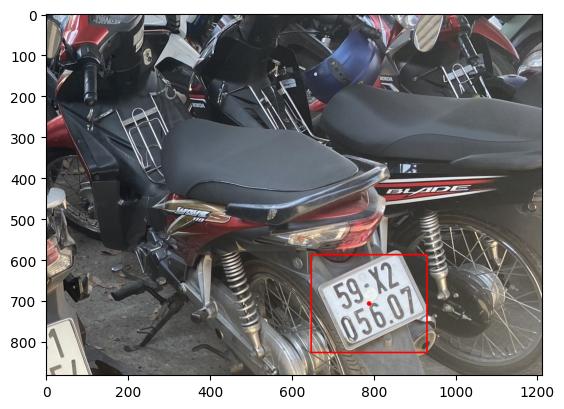

In [31]:
import cv2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
image = cv2.imread("D:\\Number Plate Region\\Full_Yolo\\Image_Test\\img_39.jpg")
# image = cv2.imread("D:\Number Plate Region\Full_Yolo\Image_Test\\img_2.jpg")
# image = cv2.imread("D:\\Number Plate Region\\Mydata\\ValImage\\0051_00959_b.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

resized_image = cv2.resize(image, (416, 416), interpolation = cv2.INTER_AREA)
image_pil = resized_image
resized_image = resized_image.astype(float) 
resized_image /= 255

img = np.expand_dims(resized_image, axis=0)
prediction = yolo.model.predict(img)
xywhcp = decode(prediction[2][0],prediction[1][0],prediction[0][0] , class_num=num_classes, threshold=0.5, version=2)

if len(xywhcp) > 0:
    xywhcp = soft_nms(xywhcp, num_classes, 0.5)

print(xywhcp)
idx = len(xywhcp) -1 

img_draw = Image.fromarray(image)
draw = ImageDraw.Draw(img_draw)
for i in range(len(xywhcp)):
    x = int(xywhcp[0][0] * image.shape[1])
    y = int(xywhcp[0][1] * image.shape[0])
    w = int(xywhcp[0][2] * image.shape[1]*1.4)
    h = int(xywhcp[0][3] * image.shape[0]*1.2)
    class_i = int(xywhcp[0][5])

    # Vẽ hình tròn
    radius = 5
    draw.ellipse((x - radius, y - radius, x + radius, y + radius), fill='red')

    # Vẽ hình chữ nhật
    x_min, y_min = int(x - w / 2), int(y - h / 2)
    x_max, y_max = int(x + w / 2), int(y + h / 2)
    draw.rectangle([x_min, y_min, x_max, y_max], outline='red', width=4)

plt.imshow(img_draw)
plt.show()